# Graph Classification: Protein Dataset
- Goal: Classify each protein as an enzyme, a binary classification task
- This dataset does not contain any edge features

## Dataset

In [1]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='./data', name='PROTEINS').shuffle()

print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: PROTEINS(1113)
-----------------------
Number of graphs: 1113
Number of nodes: 23
Number of features: 3
Number of classes: 2


In [2]:
from torch_geometric.loader import DataLoader

train_dataset = dataset[: int(len(dataset) * 0.8)]
val_dataset = dataset[int(len(dataset) * 0.8): int(len(dataset) * 0.9)]
test_dataset = dataset[int(len(dataset) * 0.9):]

print(f'Training set = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set = {len(test_dataset)} graphs')

Training set = 890 graphs
Validation set = 111 graphs
Test set = 112 graphs


## Mini-batch: 64 graphs
- This means each batch will contain up to 64 graphs

In [3]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

print('\nTrain loader:')
for i, batch in enumerate(train_loader):
    print(f'- Batch {i}: {batch}')

print('\nValidation loader:')
for i, batch in enumerate(val_loader):
    print(f'- Batch {i}: {batch}')

print('\nTest loader:')
for i, batch in enumerate(test_loader):
    print(f' - Batch {i}: {batch}')


Train loader:
- Batch 0: DataBatch(edge_index=[2, 9864], x=[2686, 3], y=[64], batch=[2686], ptr=[65])
- Batch 1: DataBatch(edge_index=[2, 9256], x=[2401, 3], y=[64], batch=[2401], ptr=[65])
- Batch 2: DataBatch(edge_index=[2, 11020], x=[2916, 3], y=[64], batch=[2916], ptr=[65])
- Batch 3: DataBatch(edge_index=[2, 9536], x=[2506, 3], y=[64], batch=[2506], ptr=[65])
- Batch 4: DataBatch(edge_index=[2, 10234], x=[2797, 3], y=[64], batch=[2797], ptr=[65])
- Batch 5: DataBatch(edge_index=[2, 6898], x=[1871, 3], y=[64], batch=[1871], ptr=[65])
- Batch 6: DataBatch(edge_index=[2, 10262], x=[2796, 3], y=[64], batch=[2796], ptr=[65])
- Batch 7: DataBatch(edge_index=[2, 8900], x=[2428, 3], y=[64], batch=[2428], ptr=[65])
- Batch 8: DataBatch(edge_index=[2, 8904], x=[2249, 3], y=[64], batch=[2249], ptr=[65])
- Batch 9: DataBatch(edge_index=[2, 11942], x=[3211, 3], y=[64], batch=[3211], ptr=[65])
- Batch 10: DataBatch(edge_index=[2, 8080], x=[2167, 3], y=[64], batch=[2167], ptr=[65])
- Batch 11: 

## Layer Composition
- Linear -> BatchNorm -> ReLU -> Linear -> ReLU

### GIN Model

In [20]:
import torch
# torch.manual_seed(42)

import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GINConv, GCNConv
from torch_geometric.nn import global_add_pool, global_mean_pool

class GIN(torch.nn.Module):
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        torch.manual_seed(42)

        # GIN layers
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h),
                       ReLU(),
                       Linear(dim_h, dim_h),
                       ReLU())
        )
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h),
                       BatchNorm1d(dim_h),
                       ReLU(),
                       Linear(dim_h, dim_h),
                       ReLU())
        )
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h),
                       BatchNorm1d(dim_h),
                       ReLU(),
                       Linear(dim_h, dim_h),
                       ReLU())
        )

        # Graph-level pooling layer /readout layer
        # Here we add each layer as recommended in GIN paper
        self.lin1 = Linear(dim_h * 3, dim_h * 3)

        # Final Classification head
        self.lin2 = Linear(dim_h * 3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embedding
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        # print(h.shape)

        return F.log_softmax(h, dim=1)

### GCN Model

In [67]:
class GCN(torch.nn.Module):
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GIN layers
        self.conv1 = GCNConv(
            dataset.num_node_features,
            dim_h
        )
        self.conv2 = GCNConv(
            dim_h,
            dim_h
        )
        self.conv3 = GCNConv(
            dim_h,
            dim_h
        )

        # Graph-level pooling layer /readout layer
        # Here we add each layer as recommended in GIN paper
        self.lin1 = Linear(dim_h * 3, dim_h * 3)

        # Final Classification head
        self.lin2 = Linear(dim_h * 3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embedding
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_mean_pool(h1, batch)
        h2 = global_mean_pool(h2, batch)
        h3 = global_mean_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        # print(h.shape)

        return F.log_softmax(h, dim=1)

## Train Test functions

In [5]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

def train(model, loader, epochs=100):
    """Train and validate the model with given params

    :param model:
    :param loader:
    :param epochs:
    :return: model
    """

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    model.train()
    for epoch in range(epochs + 1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

            loss.backward()

            # Validation
            val_loss, val_acc = test(model, val_loader)
        # Print metrics every 20 epochs
        if epoch % 20 == 0:
            print(f'Epoch {epoch:>3} \
                  | Train Loss: {total_loss:.2f} \
                  | Train Acc: {acc*100:>5.2f}% \
                  | ValLoss: {val_loss:.2f}  \
                  | Val Acc: {val_acc*100:.2f}%')
    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc



Model with dim_h = 32

In [6]:
gin = GIN(dim_h=32)
gin

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=96, out_features=96, bias=True)
  (lin2): Linear(in_features=96, out_features=2, bias=True)
)

In [69]:
gcn = GCN(dim_h=32)
gcn

GCN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin1): Linear(in_features=96, out_features=96, bias=True)
  (lin2): Linear(in_features=96, out_features=2, bias=True)
)

Let's train the models!

## Train the models

In [7]:
gin = train(gin, train_loader, 100)

Epoch   0                   | Train Loss: 0.69                   | Train Acc: 64.41%                   | ValLoss: 0.68                    | Val Acc: 58.13%
Epoch  20                   | Train Loss: 0.67                   | Train Acc: 64.94%                   | ValLoss: 0.69                    | Val Acc: 56.72%
Epoch  40                   | Train Loss: 0.67                   | Train Acc: 65.01%                   | ValLoss: 0.67                    | Val Acc: 59.26%
Epoch  60                   | Train Loss: 0.67                   | Train Acc: 64.94%                   | ValLoss: 0.67                    | Val Acc: 58.98%
Epoch  80                   | Train Loss: 0.67                   | Train Acc: 64.92%                   | ValLoss: 0.66                    | Val Acc: 59.54%
Epoch 100                   | Train Loss: 0.67                   | Train Acc: 64.99%                   | ValLoss: 0.66                    | Val Acc: 59.54%


In [70]:
gcn = train(gcn, train_loader, 100)

Epoch   0                   | Train Loss: 0.70                   | Train Acc: 35.72%                   | ValLoss: 0.69                    | Val Acc: 38.83%
Epoch  20                   | Train Loss: 0.69                   | Train Acc: 35.58%                   | ValLoss: 0.69                    | Val Acc: 39.68%
Epoch  40                   | Train Loss: 0.69                   | Train Acc: 35.61%                   | ValLoss: 0.69                    | Val Acc: 41.37%
Epoch  60                   | Train Loss: 0.69                   | Train Acc: 35.53%                   | ValLoss: 0.69                    | Val Acc: 40.53%
Epoch  80                   | Train Loss: 0.69                   | Train Acc: 35.65%                   | ValLoss: 0.69                    | Val Acc: 41.66%
Epoch 100                   | Train Loss: 0.69                   | Train Acc: 35.55%                   | ValLoss: 0.69                    | Val Acc: 41.37%


## Test the model

In [89]:
test_loss_gin, test_acc_gin = test(gin, test_loader)
print(f'Test Loss: {test_loss_gin:.2f} | Test Acc: {test_acc_gin * 100:.2f}%')

test_loss_gcn, test_acc_gcn = test(gcn, test_loader)
print(f'Test Loss: {test_loss_gcn:.2f} | Test Acc: {test_acc_gcn * 100:.2f}%')

Test Loss: 0.68 | Test Acc: 62.76%
Test Loss: 0.69 | Test Acc: 37.76%


We can compare this test score with other GCNs under sampe setting with a simple global mean pooling as the readout layer. With the exact same setting, GIN often time outperfroms other architectures...

## Temp: Just for verification...

In [9]:
test_model = GIN(dim_h=32)
for data in train_loader:
    out = test_model(data.x, data.edge_index, data.batch)
    break

In [10]:
print(out.shape)
print(out)
print(out.argmax(dim=1).shape)

torch.Size([64, 2])
tensor([[-9.4696e-01, -4.9089e-01],
        [-1.9350e+00, -1.5598e-01],
        [-2.0449e-01, -1.6878e+00],
        [ 0.0000e+00, -1.7685e+01],
        [-9.6565e+00, -6.4013e-05],
        [-2.3124e-01, -1.5777e+00],
        [-5.2730e-01, -8.9208e-01],
        [-3.7837e-01, -1.1551e+00],
        [-4.4173e-01, -1.0298e+00],
        [-4.2936e-01, -1.0525e+00],
        [-7.0287e-01, -6.8352e-01],
        [-2.4153e-02, -3.7354e+00],
        [-3.5232e+00, -2.9949e-02],
        [-1.4397e+00, -2.7050e-01],
        [-4.7956e+00, -8.3007e-03],
        [-3.1306e-01, -1.3138e+00],
        [-1.4379e-01, -2.0104e+00],
        [-6.0442e-01, -7.9053e-01],
        [-3.6636e-01, -1.1817e+00],
        [-2.4232e-01, -1.5362e+00],
        [-3.1174e-01, -1.3174e+00],
        [-1.3868e-03, -6.5815e+00],
        [-1.0025e+00, -4.5725e-01],
        [-3.2812e-01, -1.2740e+00],
        [-3.0692e-03, -5.7879e+00],
        [-5.8172e-01, -8.1856e-01],
        [-2.9627e-01, -1.3610e+00],
        

## Analyzing the mistakes done by the model

Graph Analysis For GIN


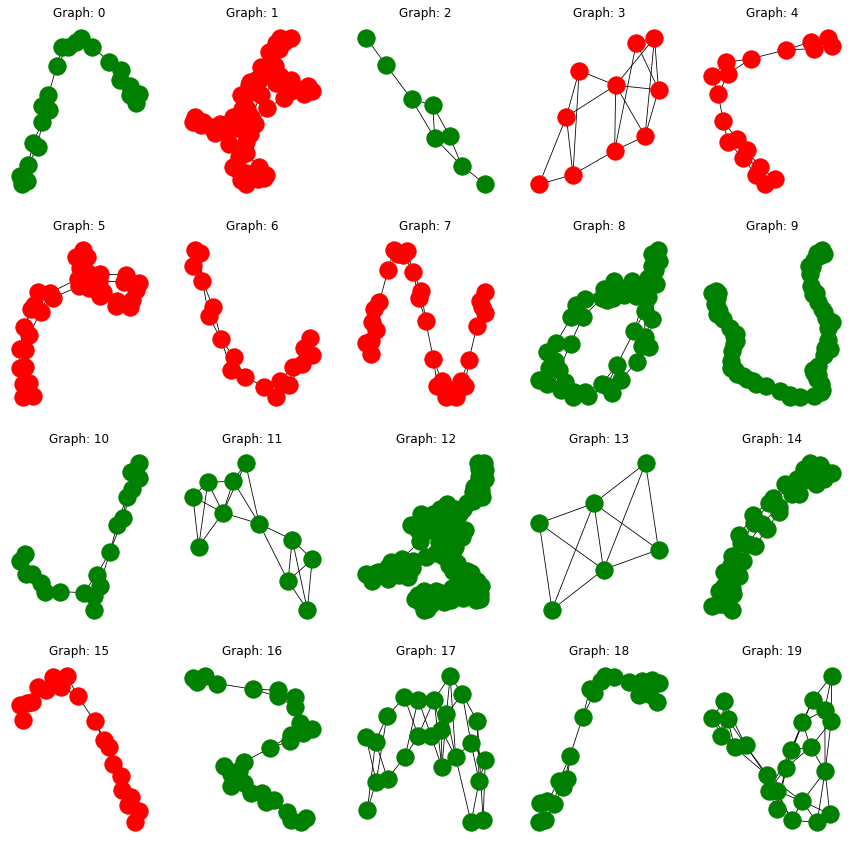

In [51]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def draw_graphs(model, model_name):
    print(f'Graph Analysis For {model_name}')
    fig, ax = plt.subplots(4, 5, figsize=(15, 15))

    for i, data in enumerate(dataset[-20:]):
        # Give the color `green` if the prediction is correct, else `red` color
        out = model(data.x, data.edge_index, data.batch)
        color = 'green' if out.argmax(dim=1) == data.y else "red"

        # Convert protein into networkx graph
        ix = np.unravel_index(i, ax.shape)
        ax[ix].axis('off')
        ax[ix].set_title(f'Graph: {i}')
        g = to_networkx(dataset[i], to_undirected=True)
        nx.draw_networkx(g,
                     pos=nx.spring_layout(g, seed=0),
                     with_labels=False,
                     node_color=color,
                     width=0.8,
                     ax=ax[ix])

draw_graphs(gin, 'GIN')


Graph Analysis For GCN


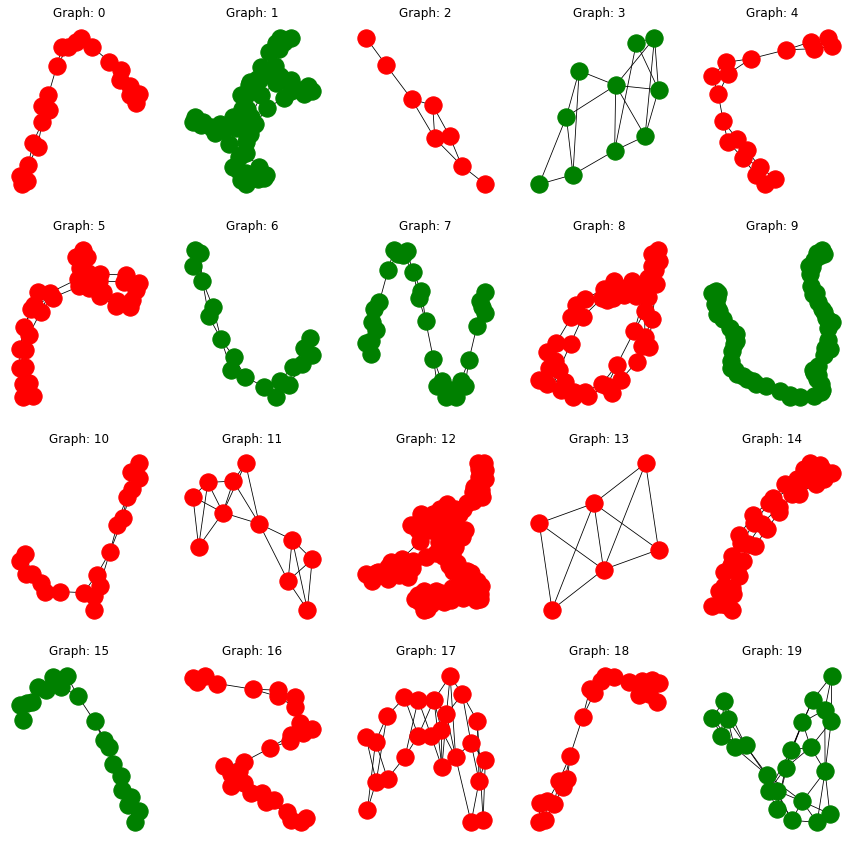

In [72]:
draw_graphs(gcn, 'GCN') # For GCN model

Here we can see the mistakes done by the model as highlighted with red color. The model have hard time recognizing these structures. We can clearly see than GCN model has hard time recognizing graph structures compared to GIN.

## Creating An Ensemble Model

In [91]:
def ensemble(model1, model2, loader):
    model1.eval()
    model2.eval()
    acc_model1 = 0
    acc_model2 = 0
    acc_ens = 0

    for data in loader:
        out_model1 = model1(data.x, data.edge_index, data.batch)
        out_model2 = model2(data.x, data.edge_index, data.batch)
        out_ens = (out_model1 + out_model2) / 2

        acc_model1 += accuracy(out_model1.argmax(dim=1), data.y) / len(loader)
        acc_model2 += accuracy(out_model2.argmax(dim=1), data.y) / len(loader)
        acc_ens += accuracy(out_ens.argmax(dim=1), data.y) / len(loader)

    print(f'Model 1 accuracy: {acc_model1 * 100:.2f}%')
    print(f'Model 2 accuracy: {acc_model2 * 100:.2f}%')
    print(f'Model 1 + Model 2 accuracy: {acc_ens * 100:.2f}%')

ensemble(gin, gcn, test_loader)


Model 1 accuracy: 62.76%
Model 2 accuracy: 40.10%
Model 1 + Model 2 accuracy: 62.76%
